# Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==29].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
28,29,5,2015-07-31,9411,737,1,1,0,1,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
1143,29,4,2015-07-30,8039,661,1,1,0,1,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
2258,29,3,2015-07-29,7564,614,1,1,0,1,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
3373,29,2,2015-07-28,8450,697,1,1,0,1,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
4488,29,1,2015-07-27,11659,889,1,1,0,1,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN


In [9]:
#Store_29
df_new_store29=df_new[df_new['store']==29]

In [10]:
# transform datatype of the variable data to datetime
df_new_store29['date'] = pd.to_datetime( df_new_store29['date'])

In [11]:
df_new_store29.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 28 to 1016123
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance       

In [12]:
# Check NAN values
missing_count = df_new_store29.isnull().sum() # the count of missing values
value_count = df_new_store29.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


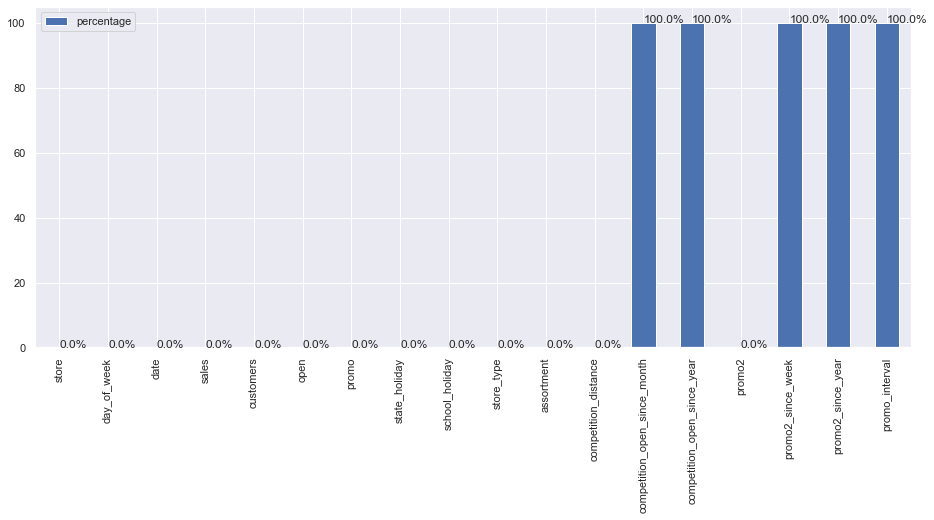

In [13]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [21]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store29=df_new_store29.drop(['competition_open_since_month', 'competition_open_since_year','promo2_since_week','promo2_since_year','promo_interval'], axis = 1)

In [22]:
df_new_store29.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2'],
      dtype='object')

In [23]:
df_new_store29.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2
28,29,5,2015-07-31,9411,737,1,1,0,1,d,c,2170.0,0
1143,29,4,2015-07-30,8039,661,1,1,0,1,d,c,2170.0,0
2258,29,3,2015-07-29,7564,614,1,1,0,1,d,c,2170.0,0
3373,29,2,2015-07-28,8450,697,1,1,0,1,d,c,2170.0,0
4488,29,1,2015-07-27,11659,889,1,1,0,1,d,c,2170.0,0


In [24]:
df_new_store29.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 28 to 1016123
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   store                 942 non-null    int64         
 1   day_of_week           942 non-null    int64         
 2   date                  942 non-null    datetime64[ns]
 3   sales                 942 non-null    int64         
 4   customers             942 non-null    int64         
 5   open                  942 non-null    int64         
 6   promo                 942 non-null    int64         
 7   state_holiday         942 non-null    object        
 8   school_holiday        942 non-null    int64         
 9   store_type            942 non-null    object        
 10  assortment            942 non-null    object        
 11  competition_distance  942 non-null    float64       
 12  promo2                942 non-null    int64         
dtypes: datetime64[n

In [25]:
# Let's copy the dataset
df_store29 = df_new_store29.copy()

In [26]:
df_store29.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2
28,29,5,2015-07-31,9411,737,1,1,0,1,d,c,2170.0,0
1143,29,4,2015-07-30,8039,661,1,1,0,1,d,c,2170.0,0
2258,29,3,2015-07-29,7564,614,1,1,0,1,d,c,2170.0,0
3373,29,2,2015-07-28,8450,697,1,1,0,1,d,c,2170.0,0
4488,29,1,2015-07-27,11659,889,1,1,0,1,d,c,2170.0,0


**Descriptive Statistics**

In [27]:
df_store29.describe().T

,count,mean,std,min,25%,50%,75%,max
store,942.0,29.000000,0.000000,29.0,29.0,29.0,29.0,29.0
day_of_week,942.0,3.997877,1.998404,1.0,2.0,4.0,6.0,7.0
sales,942.0,6090.403397,3433.366553,0.0,4972.5,6361.5,8072.0,15758.0
customers,942.0,540.587049,277.347395,0.0,498.5,598.0,703.0,1153.0
open,942.0,0.826964,0.378479,0.0,1.0,1.0,1.0,1.0
promo,942.0,0.382166,0.486175,0.0,0.0,0.0,1.0,1.0
school_holiday,942.0,0.180467,0.384780,0.0,0.0,0.0,0.0,1.0
competition_distance,942.0,2170.000000,0.000000,2170.0,2170.0,2170.0,2170.0,2170.0
promo2,942.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [29]:
# separate numerical and categorical attributes
num_attributes = df_store29.select_dtypes( include = 'number')
cate_attributes = df_store29.select_dtypes( include = 'object')

**Numerical Attributes**

In [30]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,29.0,29.0,0.0,29.000000,29.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,15758.0,15758.0,6090.403397,6361.5,3431.543688,-0.308371,-0.055581
3,customers,0.0,1153.0,1153.0,540.587049,598.0,277.200144,-0.885889,0.082139
4,open,0.0,1.0,1.0,0.826964,1.0,0.378278,-1.731453,1.000047
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.180467,0.0,0.384576,1.664393,0.771837
7,competition_distance,2170.0,2170.0,0.0,2170.000000,2170.0,0.000000,0.000000,0.000000
8,promo2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000


**Categorical Attributes**

In [31]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday    5
store_type       1
assortment       1
dtype: int64

In [33]:
#Let's check the unique values
print(df_store29['state_holiday'].unique())
print(df_store29['store_type'].unique())
print(df_store29['assortment'].unique())

['0' 'a' 'b' 'c' 0]
['d']
['c']


In [35]:
df_store29.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2'],
      dtype='object')

# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

Response Variable (target)

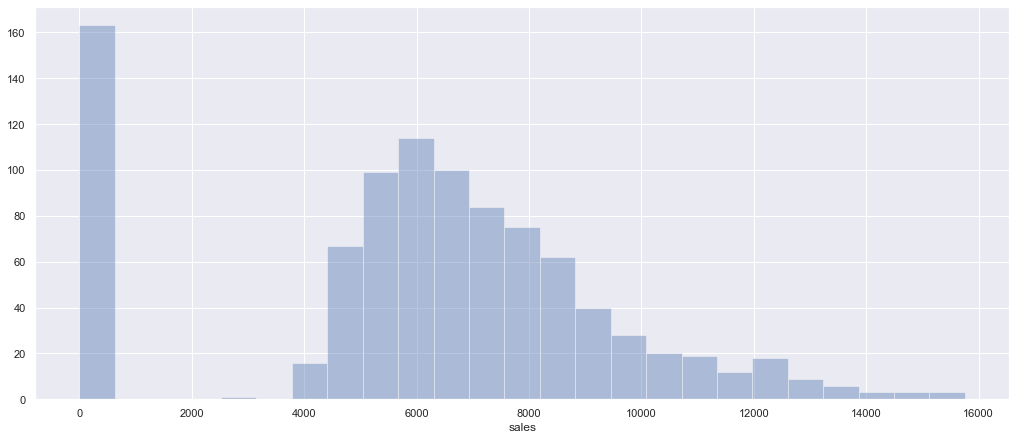

In [38]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store29['sales'], kde = False);
plt.show()

**Numerical Variable**


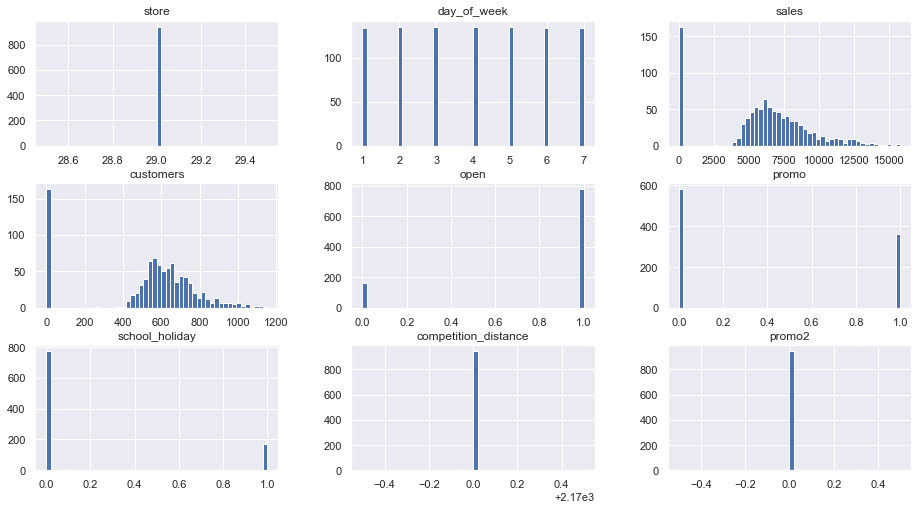

In [39]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [40]:
df_store29['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [41]:
df_store29['open'].value_counts()
# value count of store is open or not

1    779
0    163
Name: open, dtype: int64

In [42]:
df_store29['school_holiday'].value_counts()
# value count of state_holiday

0    772
1    170
Name: school_holiday, dtype: int64

In [43]:
df_store29['state_holiday'].value_counts()
# value count of state_holiday

d    942
Name: store_type, dtype: int64

In [44]:
df_store29['assortment'].value_counts()
# value count of state_holiday

c    942
Name: assortment, dtype: int64

In [45]:
df_store29['competition_distance'].value_counts()
# value count of state_holiday

2170.0    942
Name: competition_distance, dtype: int64

In [46]:
df_store29['promo2'].value_counts()
# value count of state_holiday

0    942
Name: promo2, dtype: int64

**Categorical Variable**


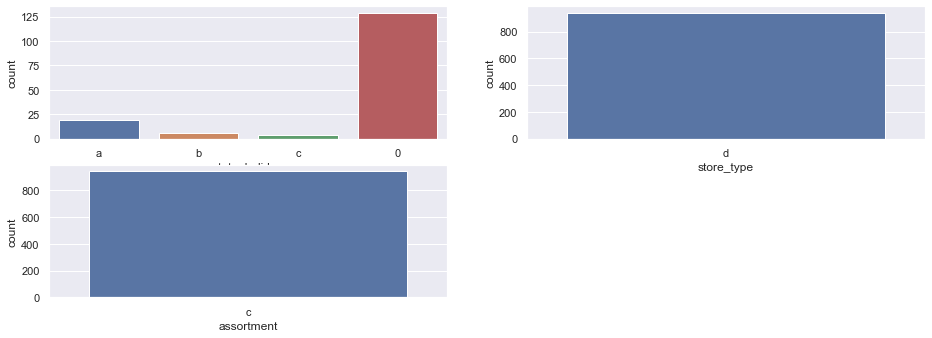

In [49]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store29[df_store29['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store29, x = df_store29['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store29, x = df_store29['assortment'])

plt.show()

In [50]:
# Zero values in sales 
df_store29[df_store29['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2
5603,29,7,2015-07-26,0,0,0,0,0,0,d,c,2170.0,0
13408,29,7,2015-07-19,0,0,0,0,0,0,d,c,2170.0,0
21213,29,7,2015-07-12,0,0,0,0,0,0,d,c,2170.0,0
29018,29,7,2015-07-05,0,0,0,0,0,0,d,c,2170.0,0
36823,29,7,2015-06-28,0,0,0,0,0,0,d,c,2170.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987133,29,7,2013-01-27,0,0,0,0,0,0,d,c,2170.0,0
994938,29,7,2013-01-20,0,0,0,0,0,0,d,c,2170.0,0
1002743,29,7,2013-01-13,0,0,0,0,0,0,d,c,2170.0,0
1010548,29,7,2013-01-06,0,0,0,0,0,0,d,c,2170.0,0


In [51]:
df_store29.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 28 to 1016123
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   store                 942 non-null    int64         
 1   day_of_week           942 non-null    int64         
 2   date                  942 non-null    datetime64[ns]
 3   sales                 942 non-null    int64         
 4   customers             942 non-null    int64         
 5   open                  942 non-null    int64         
 6   promo                 942 non-null    int64         
 7   state_holiday         942 non-null    object        
 8   school_holiday        942 non-null    int64         
 9   store_type            942 non-null    object        
 10  assortment            942 non-null    object        
 11  competition_distance  942 non-null    float64       
 12  promo2                942 non-null    int64         
dtypes: datetime64[n


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'd'

-    All the rows of column-assortment belongs to 'c'

-    All the rows of columns-competition_distance to 2170

-    All the rows of promo2 belogs to 0

**Bivariate Analysis**

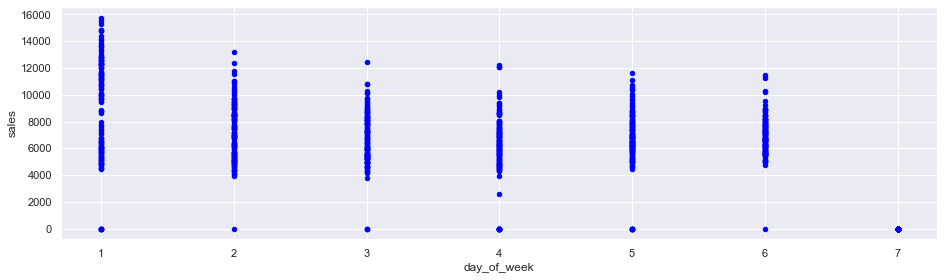

In [52]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store29[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

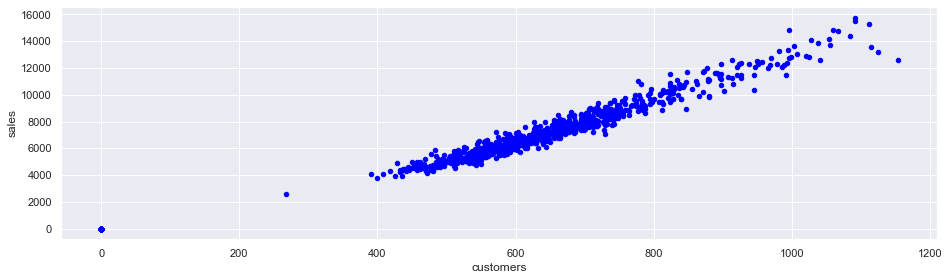

In [53]:
#Let's draw a scatter plot between Sales and Customers
df_store29[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

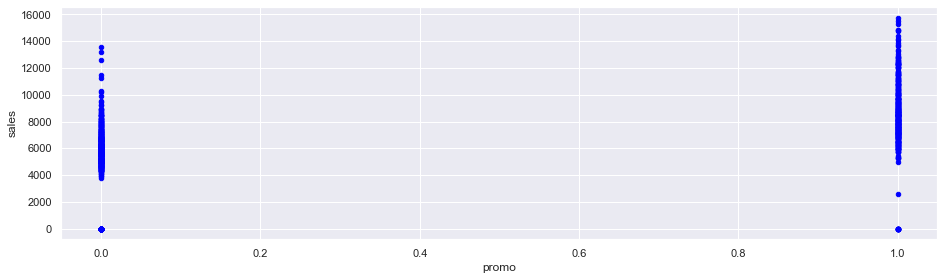

In [54]:
#Let's now draw a scatter plot between Sales and promo
df_store29[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

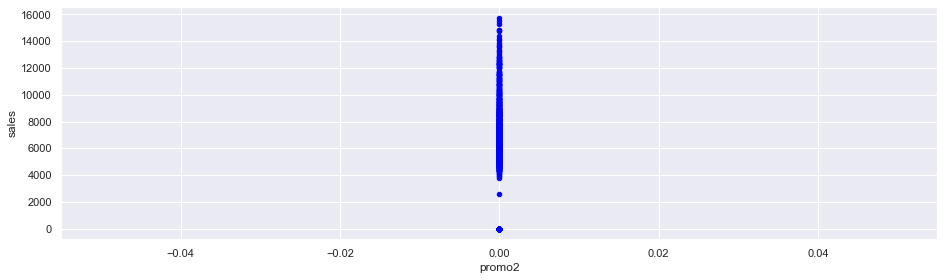

In [58]:
#Let's now draw a scatter plot between Sales and promo
df_store29[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

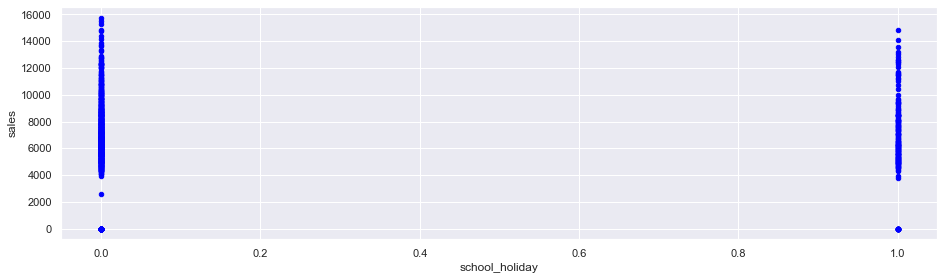

In [59]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store29[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

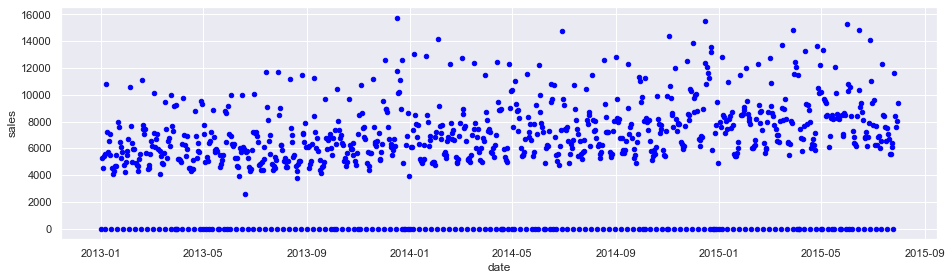

In [60]:
#lets now draw a scatter plot between Sales and date
df_store29[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

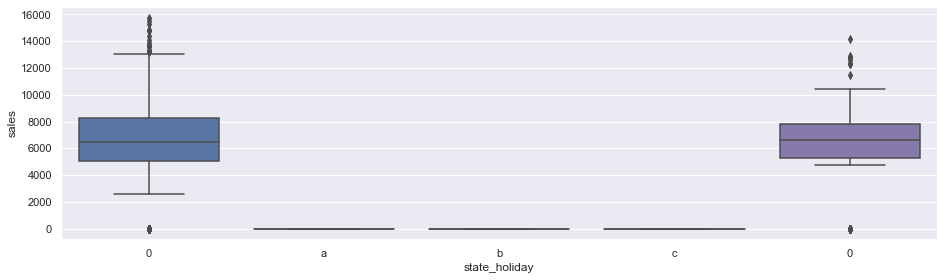

In [62]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store29['state_holiday'],
            y = df_store29['sales'])
plt.show()

**Multivariate Analysis**

**Numerical Attributes**



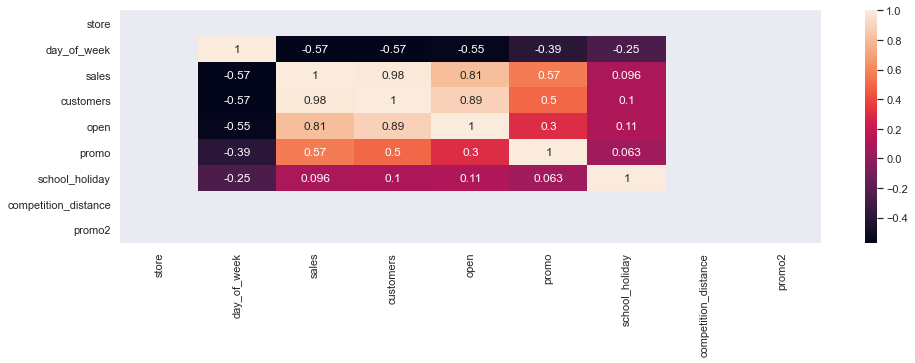

In [63]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

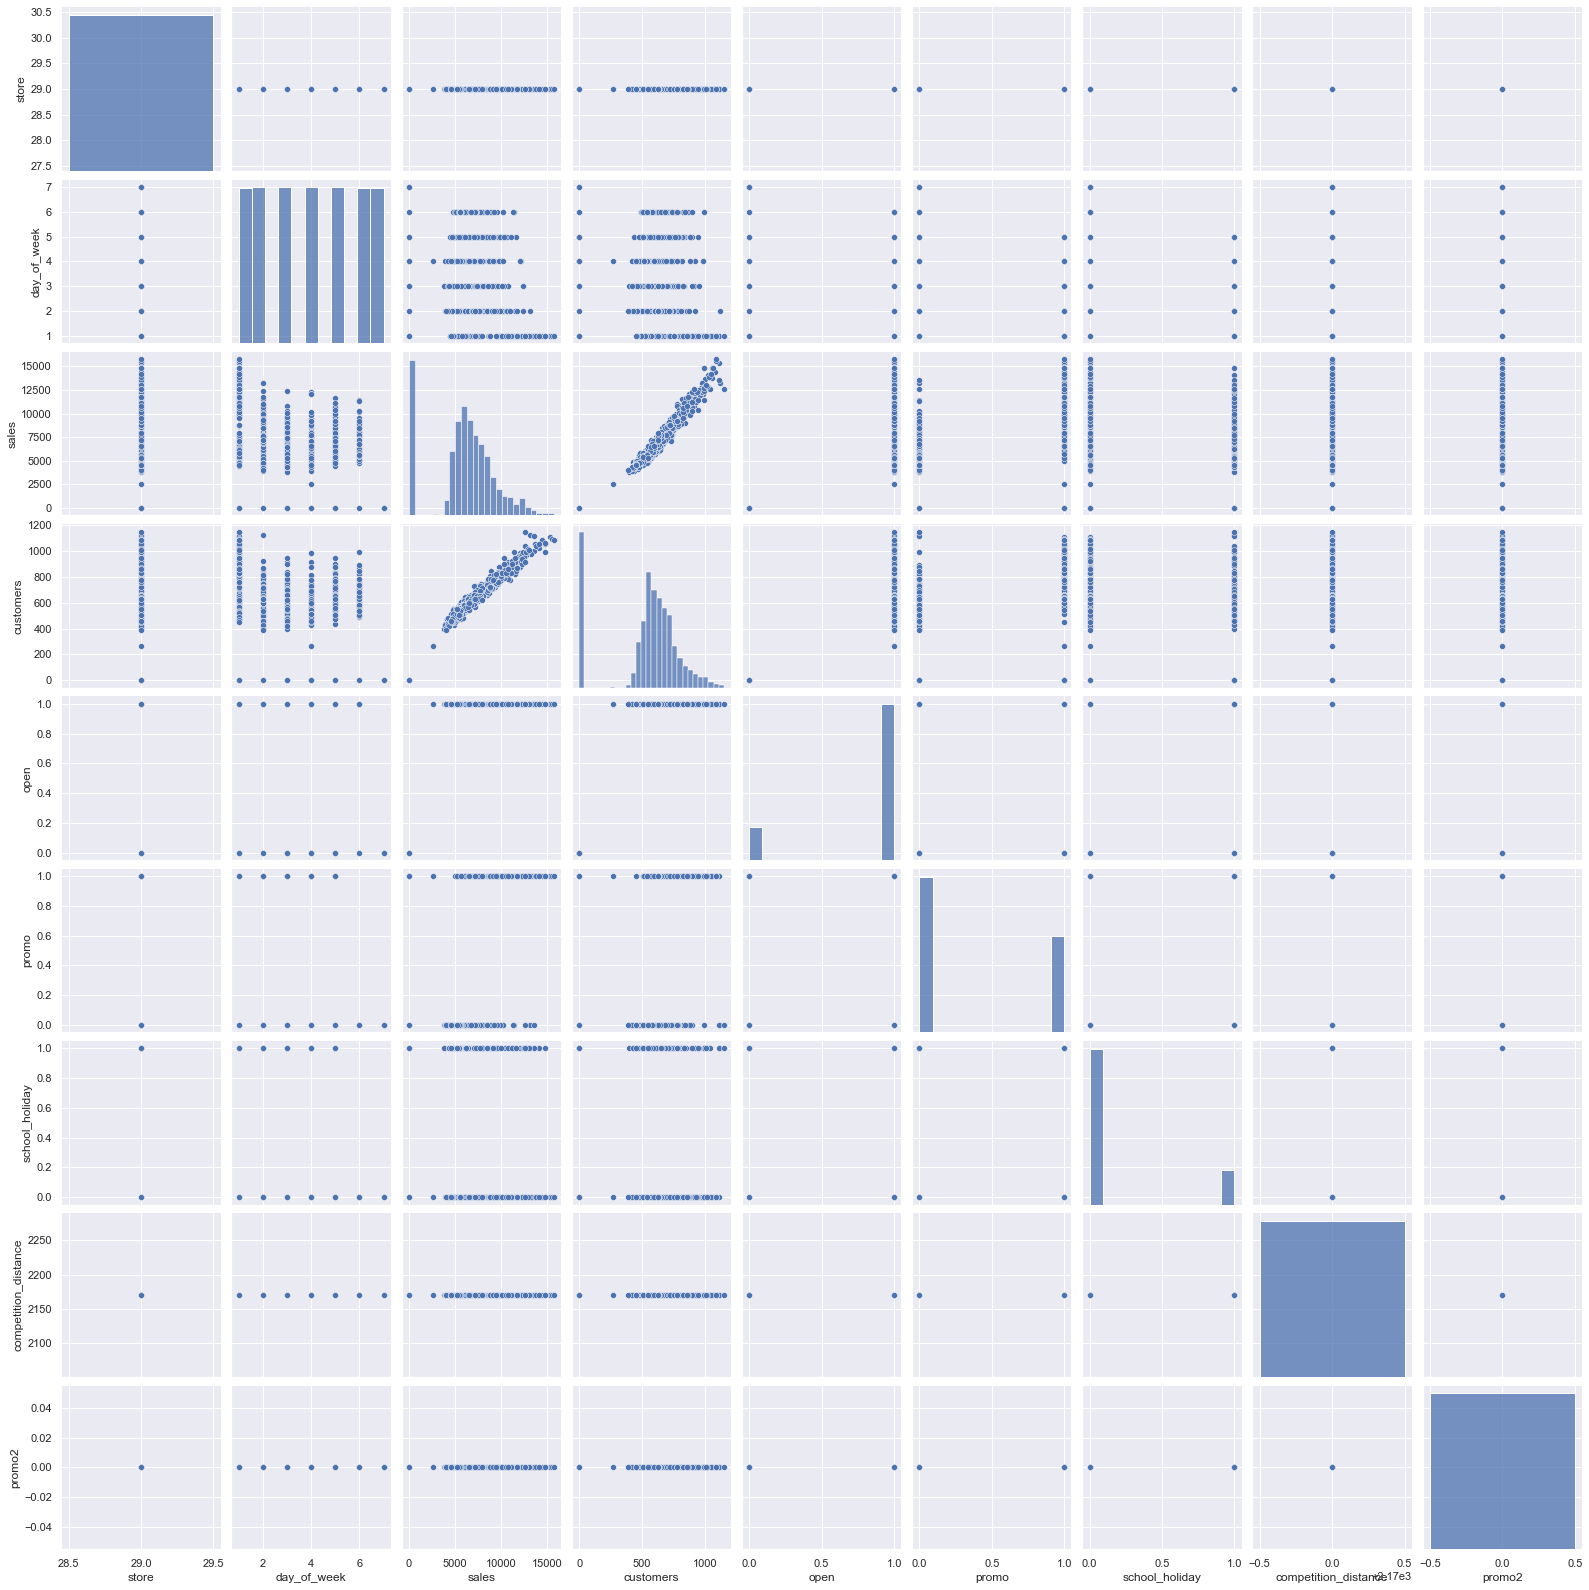

In [64]:
#pairplot with hue sales
sns.pairplot(df_store29)
# to show
plt.show()

**Some insights from EDA**

   - store_type,assortment,competition_distance

   - Day1 and Day2 have higher sales than other days

   - promo is correlated to sales

   - Promo2 doesn't have any effect on sales becuase it's value is equal to 1

   - There is no sale on a = public holiday, b = Easter holiday, c = Christmas

   - There is some effect of school holiday on sales

In [66]:
df_store29.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2'],
      dtype='object')

In [67]:
#We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store29_new=df_store29.drop(['store_type', 'assortment','competition_distance'], axis = 1)
df_store29_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 28 to 1016123
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [68]:
df_store29_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2'],
      dtype='object')

In [69]:
df_store29_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
28,29,5,2015-07-31,9411,737,1,1,0,1,0
1143,29,4,2015-07-30,8039,661,1,1,0,1,0
2258,29,3,2015-07-29,7564,614,1,1,0,1,0
3373,29,2,2015-07-28,8450,697,1,1,0,1,0
4488,29,1,2015-07-27,11659,889,1,1,0,1,0


In [70]:
# saving the dataframe
df_store29_new.to_csv('cleaned_df_store29.csv')

# Model Building

**ARIMA model**

In [71]:
path = "cleaned_df_store29.csv"
df_store29_new = pd.read_csv(path)
df_store29_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,28,29,5,2015-07-31,9411,737,1,1,0,1,0
1,1143,29,4,2015-07-30,8039,661,1,1,0,1,0
2,2258,29,3,2015-07-29,7564,614,1,1,0,1,0
3,3373,29,2,2015-07-28,8450,697,1,1,0,1,0
4,4488,29,1,2015-07-27,11659,889,1,1,0,1,0


In [72]:
df_store29_new=df_store29_new[::-1].reset_index()
df_store29_new.head()

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,941,1016123,29,2,2013-01-01,0,0,0,0,a,1,0
1,940,1015008,29,3,2013-01-02,5269,550,1,0,0,1,0
2,939,1013893,29,4,2013-01-03,4554,456,1,0,0,1,0
3,938,1012778,29,5,2013-01-04,5411,505,1,0,0,1,0
4,937,1011663,29,6,2013-01-05,5564,537,1,0,0,0,0


In [73]:
df_store29_new=df_store29_new.drop(['Unnamed: 0'], axis = 1)
df_store29_new=df_store29_new.drop(['index'], axis = 1)
df_store29_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,29,2,2013-01-01,0,0,0,0,a,1,0
1,29,3,2013-01-02,5269,550,1,0,0,1,0
2,29,4,2013-01-03,4554,456,1,0,0,1,0
3,29,5,2013-01-04,5411,505,1,0,0,1,0
4,29,6,2013-01-05,5564,537,1,0,0,0,0


In [74]:
df_store29_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           942 non-null    int64 
 1   day_of_week     942 non-null    int64 
 2   date            942 non-null    object
 3   sales           942 non-null    int64 
 4   customers       942 non-null    int64 
 5   open            942 non-null    int64 
 6   promo           942 non-null    int64 
 7   state_holiday   942 non-null    object
 8   school_holiday  942 non-null    int64 
 9   promo2          942 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 73.7+ KB


In [75]:
# transform datatype of the variable data to datetime
df_store29_new['date'] = pd.to_datetime(df_store29_new['date'])

In [76]:
indexed_df_store29_new = df_store29_new.set_index(['date'])
indexed_df_store29_new.head()
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,29,2,0,0,0,0,a,1,0
2013-01-02,29,3,5269,550,1,0,0,1,0
2013-01-03,29,4,4554,456,1,0,0,1,0
2013-01-04,29,5,5411,505,1,0,0,1,0
2013-01-05,29,6,5564,537,1,0,0,0,0


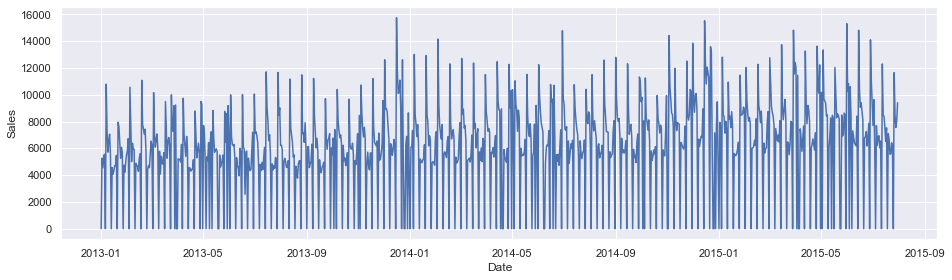

In [77]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store29_new['sales'])
plt.show()

In [79]:
#Let impute the zero values
(indexed_df_store29_new['sales']==0).sum()
# There are 163 zero value in sale column

163

In [80]:
indexed_df_store29_new['sales']=indexed_df_store29_new['sales'].replace(0, np.nan)

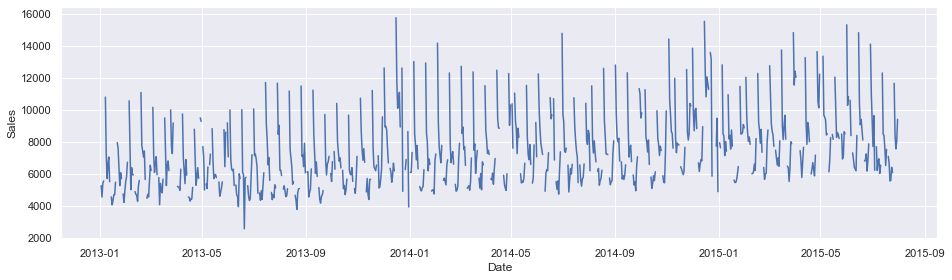

In [81]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store29_new['sales'])
plt.show()

In [82]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [83]:
indexed_df_store29_new['sales'] = imputer.fit_transform(np.array(indexed_df_store29_new['sales']).reshape(-1, 1))
indexed_df_store29_new['sales'].head()

date
2013-01-01    7364.775353
2013-01-02    5269.000000
2013-01-03    4554.000000
2013-01-04    5411.000000
2013-01-05    5564.000000
Name: sales, dtype: float64

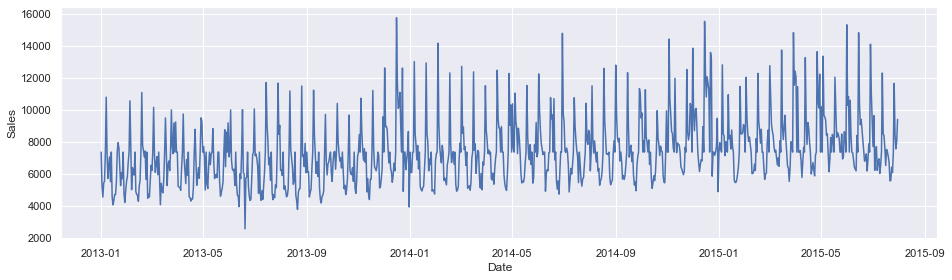

In [84]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store29_new['sales'])
plt.show()

In [85]:
(indexed_df_store29_new['sales']==0).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

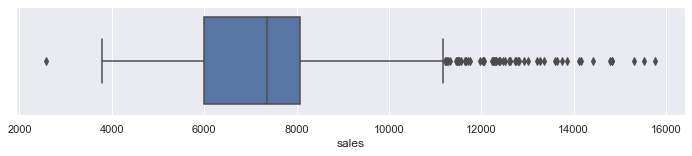

In [87]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store29_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**

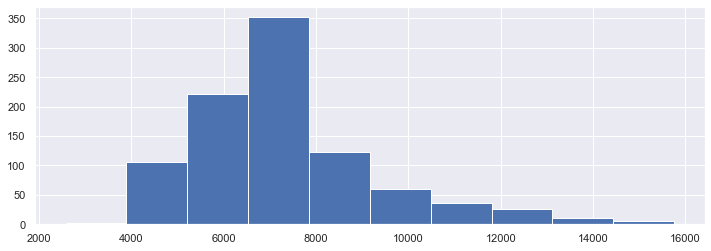

In [89]:
fig = indexed_df_store29_new['sales'].hist(figsize = (12,4))

In [91]:
percentile01 = indexed_df_store29_new['sales'].quantile(0.01)
percentile99 = indexed_df_store29_new['sales'].quantile(0.99)

In [92]:
upper_limit = percentile99
lower_limit = percentile01

In [93]:
upper_limit

13808.260000000004

In [94]:
lower_limit

4317.53

In [96]:
new_df = indexed_df_store29_new[indexed_df_store29_new['sales'] < upper_limit]
new_df.shape

(932, 9)

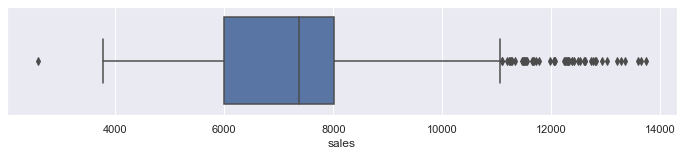

In [98]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

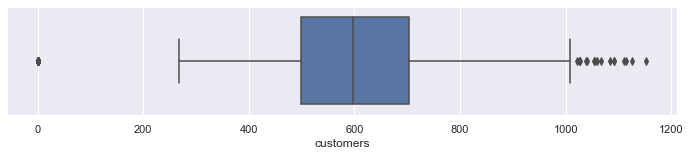

In [100]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store29_new['customers'],whis=1.5)

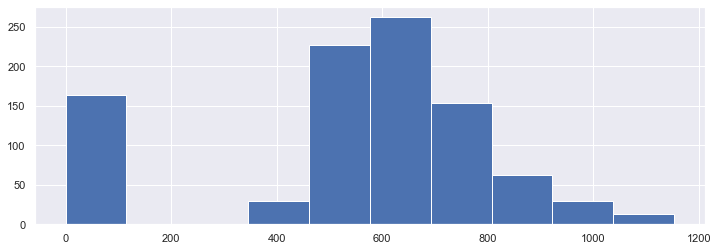

In [101]:
fig = indexed_df_store29_new['customers'].hist(figsize = (12,4))

**ADF Stationary**

In [102]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store29_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

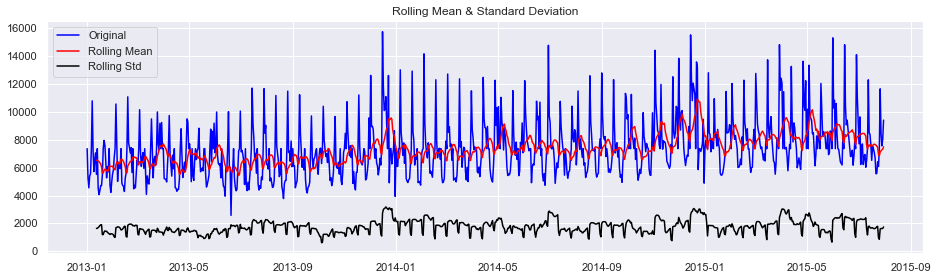

Results of Dickey Fuller Test:
Test Statistic                  -3.329632
p-value                          0.013605
#Lags Used                      21.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


In [103]:
test_stationarity(indexed_df_store29_new['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [104]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(indexed_df_store29_new['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.909372
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is less than 0.05 so The series is non-stationary**

# Let's take the log of sales to Standardize the sales values

In [211]:
new_df=indexed_df_store29_new.copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store           942 non-null    int64  
 1   day_of_week     942 non-null    int64  
 2   sales           942 non-null    float64
 3   customers       942 non-null    int64  
 4   open            942 non-null    int64  
 5   promo           942 non-null    int64  
 6   state_holiday   942 non-null    object 
 7   school_holiday  942 non-null    int64  
 8   promo2          942 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 113.6+ KB


In [106]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,29,2,7364.775353,0,0,0,a,1,0,8.904464
2013-01-02,29,3,5269.000000,550,1,0,0,1,0,8.569596
2013-01-03,29,4,4554.000000,456,1,0,0,1,0,8.423761
2013-01-04,29,5,5411.000000,505,1,0,0,1,0,8.596189
2013-01-05,29,6,5564.000000,537,1,0,0,0,0,8.624073


**Log transformation has made mean & variance constant**


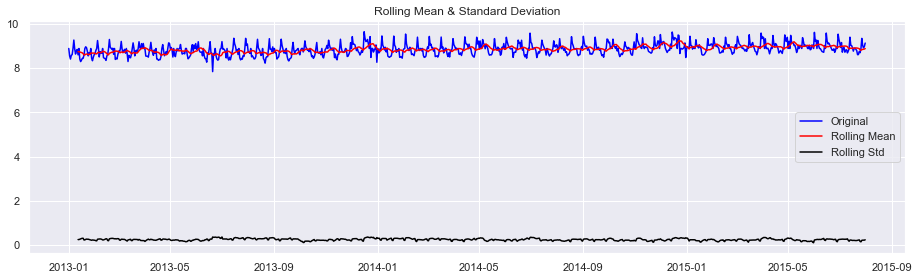

Results of Dickey Fuller Test:
Test Statistic                  -3.329632
p-value                          0.013605
#Lags Used                      21.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


In [107]:
test_stationarity(new_df['sales_log'])

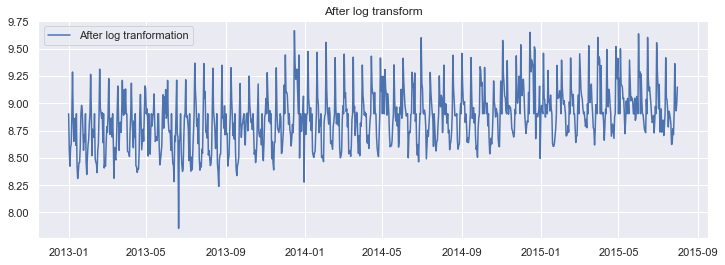

In [111]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After log transform')
plt.show()

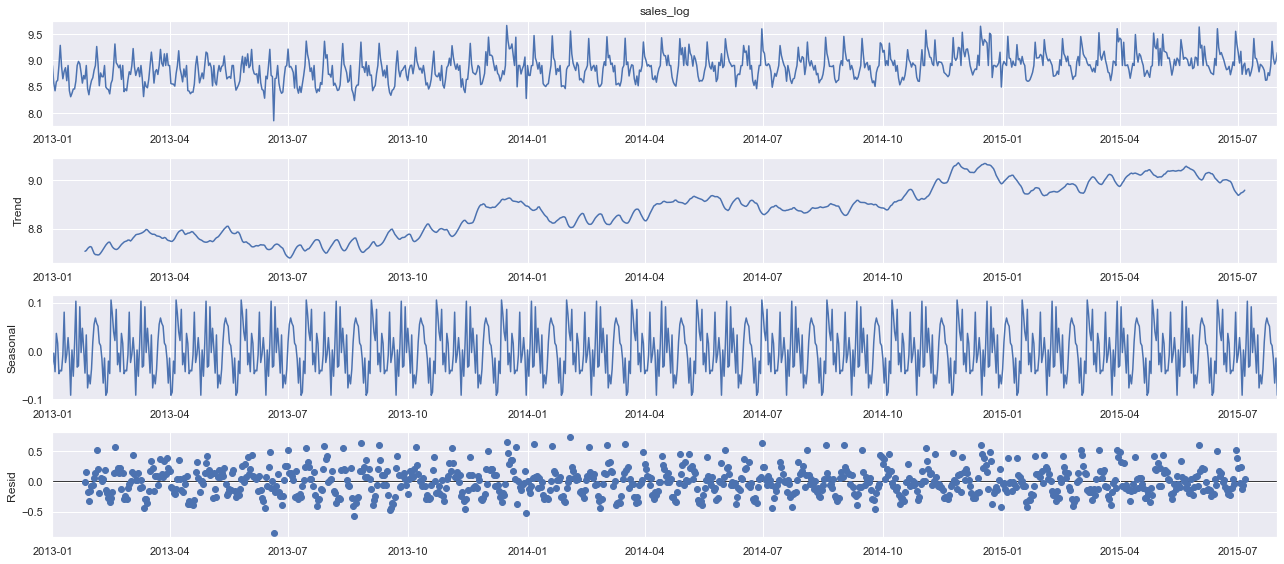

In [112]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

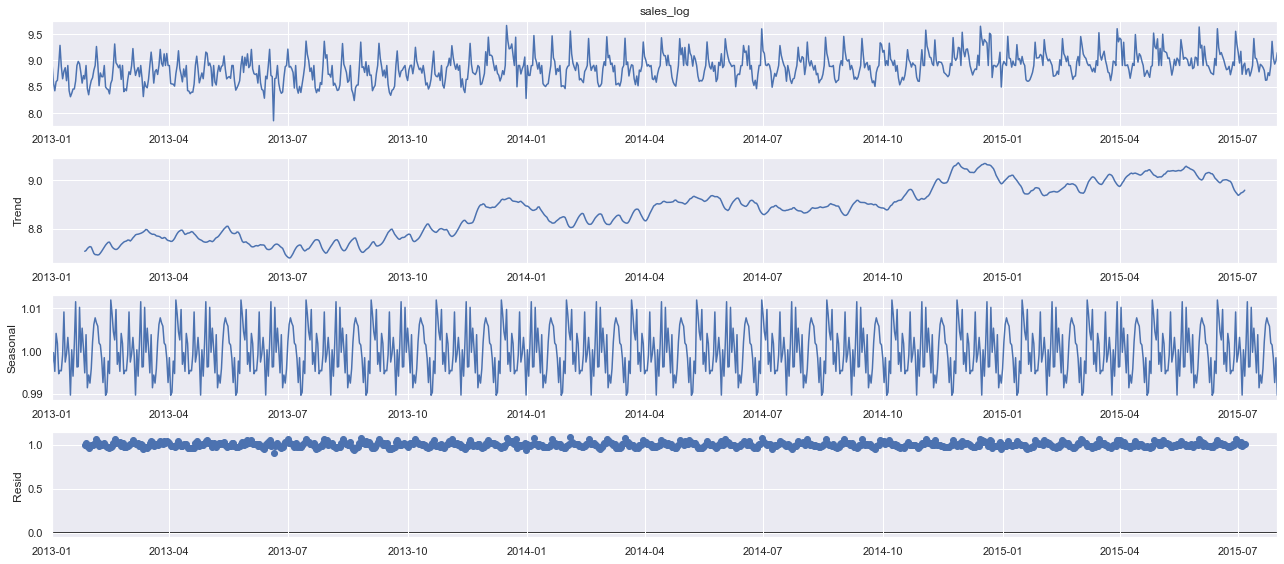

In [113]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

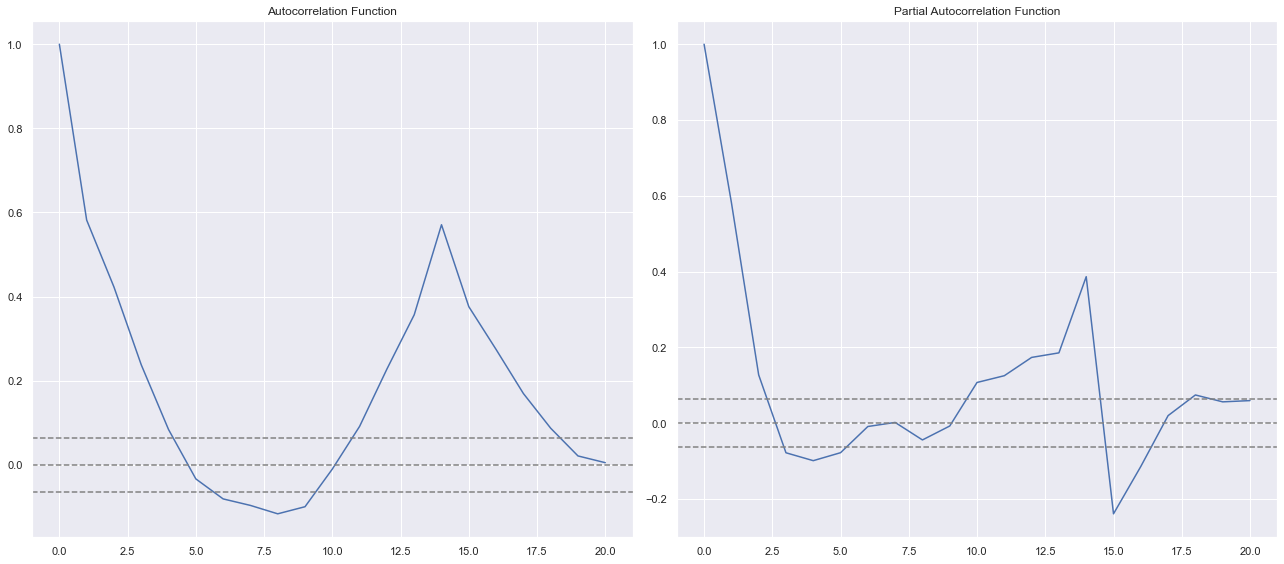

In [114]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=4. Thus, from theory, Q = 4 From the PACF graph, we see that curve touches y=0.0 line at x=3. Thus, from theory, P = 3

**Build and evaluate time series forecast**

Split time series data into training and test set


In [115]:
train_len = 750
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [116]:
print(train.shape)
print(test.shape)

(750,)
(192,)


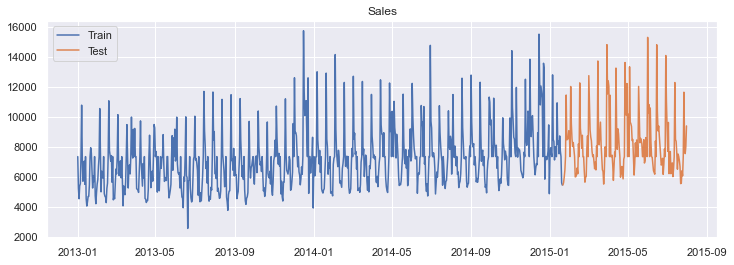

In [117]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [118]:
model = ARIMA(new_df['sales_log'], order=(3, 0, 4))
model_fit = model.fit()
print(model_fit.params)

const              8.870950
ar.L1.sales_log    0.732493
ar.L2.sales_log    0.771157
ar.L3.sales_log   -0.896238
ma.L1.sales_log   -0.281556
ma.L2.sales_log   -0.839161
ma.L3.sales_log    0.574690
ma.L4.sales_log    0.237589
dtype: float64


In [119]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    7122.046976
2013-01-02    7255.476338
2013-01-03    6119.407958
2013-01-04    5521.447458
2013-01-05    5896.273056
                 ...     
2015-07-27    7628.113406
2015-07-28    9015.415463
2015-07-29    8462.412083
2015-07-30    7810.932505
2015-07-31    8123.448289
Name: arima_forecast, Length: 942, dtype: float64

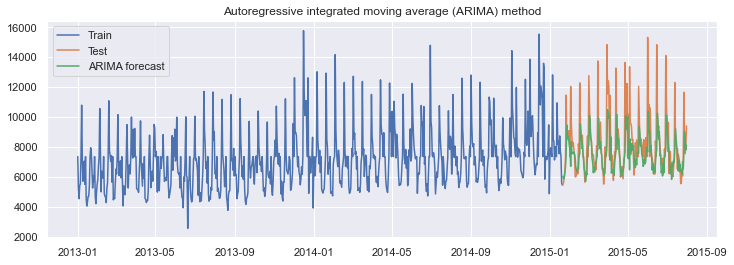

In [120]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

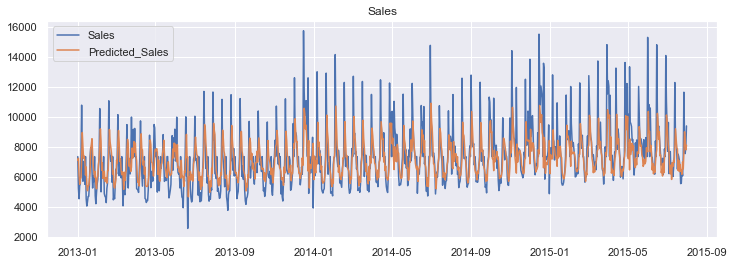

In [121]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

**Model Evalution**

In [122]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results

,Method,RMSE,MAPE
0,ARIMA,1847.92,11.58


**VAR model**

In [123]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,29,2,7364.775353,0,0,0,a,1,0,8.904464,8.870950,7122.046976
2013-01-02,29,3,5269.000000,550,1,0,0,1,0,8.569596,8.889512,7255.476338
2013-01-03,29,4,4554.000000,456,1,0,0,1,0,8.423761,8.719221,6119.407958
2013-01-04,29,5,5411.000000,505,1,0,0,1,0,8.596189,8.616395,5521.447458
2013-01-05,29,6,5564.000000,537,1,0,0,0,0,8.624073,8.682076,5896.273056


**Split the dataset to training & testing**

In [212]:
#split the dataset
nobs = 192
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(750, 9)
(192, 9)


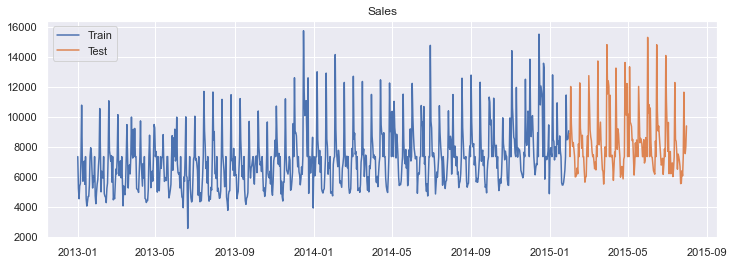

In [125]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

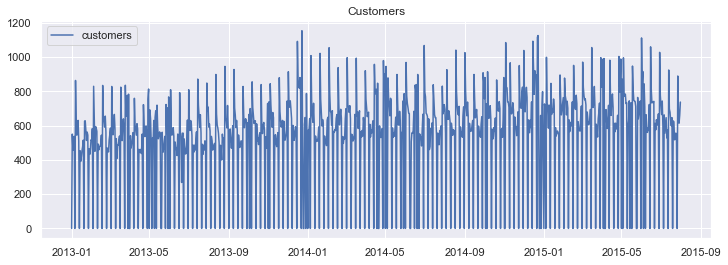

In [126]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [127]:
(new_df['customers']==0).sum()

163

In [128]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

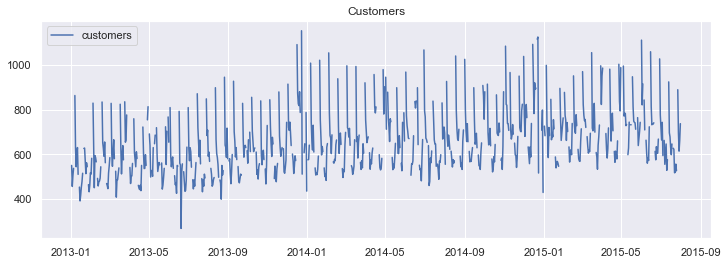

In [129]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [130]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [131]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers'].head()

date
2013-01-01    653.700899
2013-01-02    550.000000
2013-01-03    456.000000
2013-01-04    505.000000
2013-01-05    537.000000
Name: customers, dtype: float64

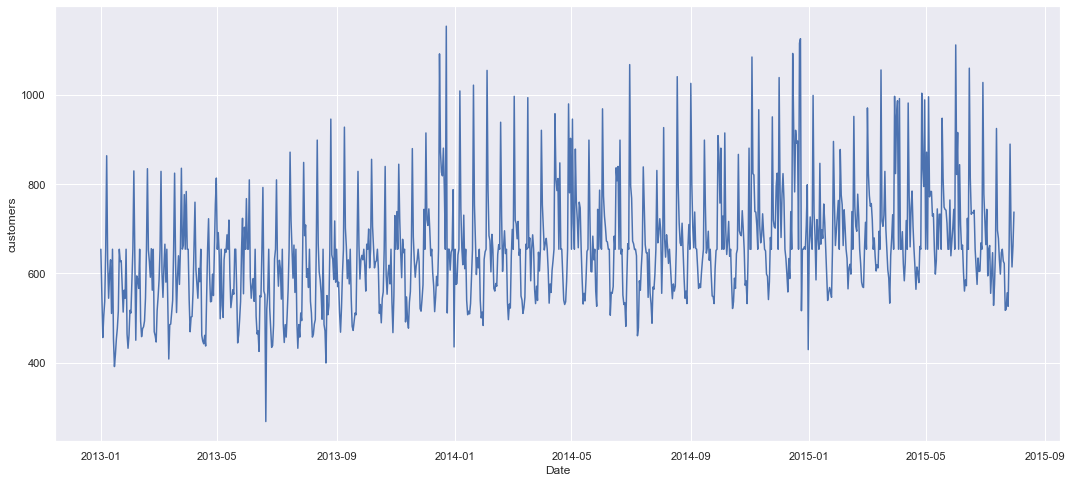

In [132]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [133]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,29,2,7364.775353,653.700899,0,0,a,1,0,8.904464,8.870950,7122.046976
2013-01-02,29,3,5269.000000,550.000000,1,0,0,1,0,8.569596,8.889512,7255.476338
2013-01-03,29,4,4554.000000,456.000000,1,0,0,1,0,8.423761,8.719221,6119.407958
2013-01-04,29,5,5411.000000,505.000000,1,0,0,1,0,8.596189,8.616395,5521.447458
2013-01-05,29,6,5564.000000,537.000000,1,0,0,0,0,8.624073,8.682076,5896.273056


**ADF test**

In [134]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

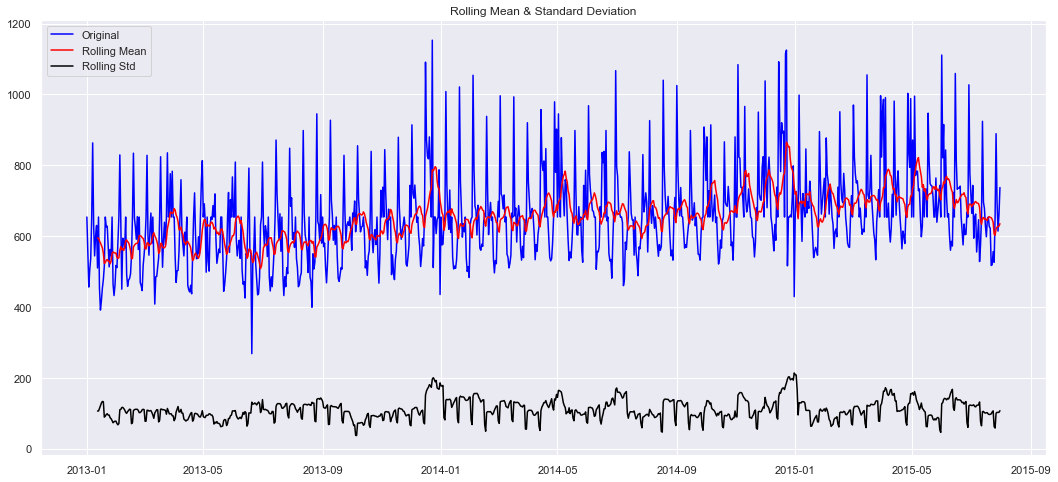

Results of Dickey Fuller Test:
Test Statistic                  -3.253264
p-value                          0.017101
#Lags Used                      20.000000
Number of Observations Used    921.000000
Critical Value (1%)             -3.437470
Critical Value (5%)             -2.864683
Critical Value (10%)            -2.568444
dtype: float64


In [135]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [136]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.863809
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is non-stationary**

**Log transformation has made mean & variance constant**

In [137]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,29,2,7364.775353,653.700899,0,0,a,1,0,8.904464,8.870950,7122.046976,6.482650
2013-01-02,29,3,5269.000000,550.000000,1,0,0,1,0,8.569596,8.889512,7255.476338,6.309918
2013-01-03,29,4,4554.000000,456.000000,1,0,0,1,0,8.423761,8.719221,6119.407958,6.122493
2013-01-04,29,5,5411.000000,505.000000,1,0,0,1,0,8.596189,8.616395,5521.447458,6.224558
2013-01-05,29,6,5564.000000,537.000000,1,0,0,0,0,8.624073,8.682076,5896.273056,6.285998


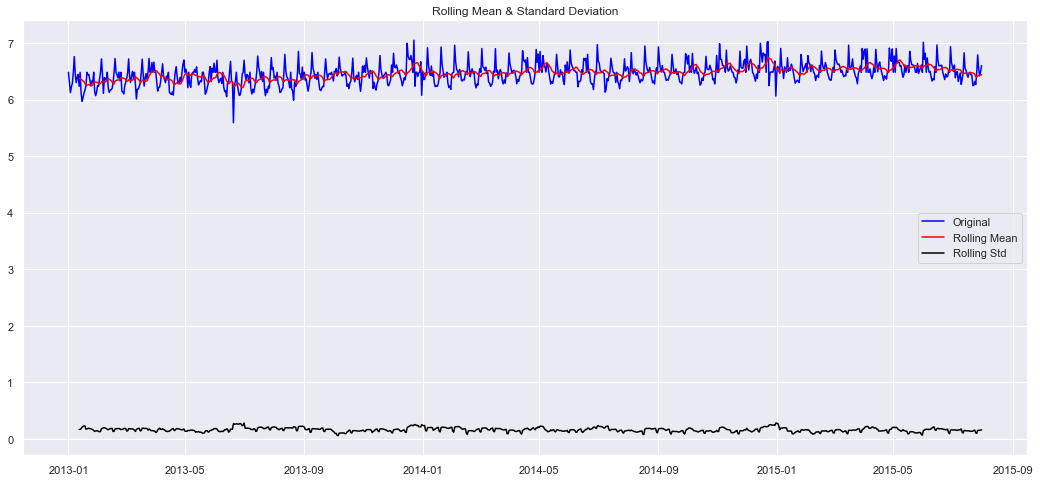

Results of Dickey Fuller Test:
Test Statistic                  -3.253264
p-value                          0.017101
#Lags Used                      20.000000
Number of Observations Used    921.000000
Critical Value (1%)             -3.437470
Critical Value (5%)             -2.864683
Critical Value (10%)            -2.568444
dtype: float64


In [138]:
test_stationarity(new_df['customers_log'])

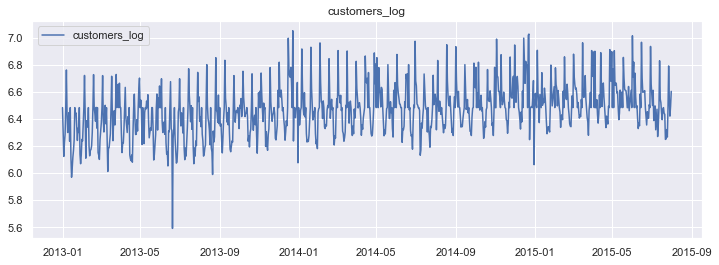

In [139]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [140]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            942 non-null    int64  
 1   day_of_week      942 non-null    int64  
 2   sales            942 non-null    float64
 3   customers        942 non-null    float64
 4   open             942 non-null    int64  
 5   promo            942 non-null    int64  
 6   state_holiday    942 non-null    object 
 7   school_holiday   942 non-null    int64  
 8   promo2           942 non-null    int64  
 9   sales_log        942 non-null    float64
 10  ar_forecast_Log  942 non-null    float64
 11  arima_forecast   942 non-null    float64
 12  customers_log    942 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 143.0+ KB


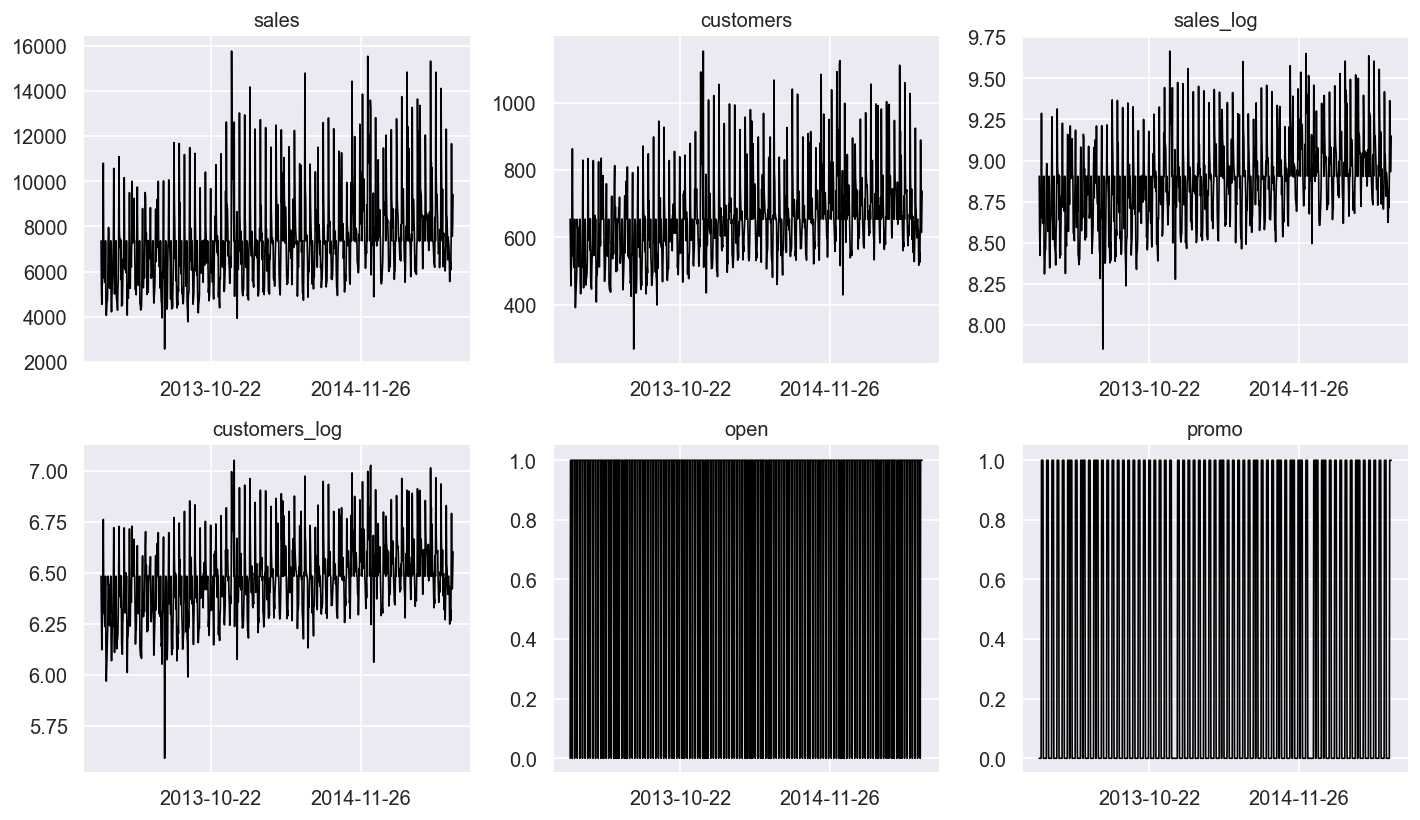

In [141]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [159]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [160]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,8.904464,6.482650
2013-01-02,8.569596,6.309918
2013-01-03,8.423761,6.122493
2013-01-04,8.596189,6.224558
2013-01-05,8.624073,6.285998
...,...,...
2015-07-27,9.363834,6.790097
2015-07-28,9.041922,6.546785
2015-07-29,8.931155,6.419995


In [161]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.631665437772886
BIC :  -9.600760380559802
FPE :  6.561767944640572e-05
HQIC:  -9.619884749623976 

Lag Order = 2
AIC :  -9.662916539184382
BIC :  -9.611364625617743
FPE :  6.359877565449702e-05
HQIC:  -9.643264475498212 

Lag Order = 3
AIC :  -9.68802785825137
BIC :  -9.615794187634847
FPE :  6.202163353135304e-05
HQIC:  -9.660490305495205 

Lag Order = 4
AIC :  -9.720389521188444
BIC :  -9.62743909572777
FPE :  6.00466772898824e-05
HQIC:  -9.684952325554795 

Lag Order = 5
AIC :  -9.732937451561748
BIC :  -9.619235175991582
FPE :  5.929798133279188e-05
HQIC:  -9.68958641881144 



In [162]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-9.154,-9.144,0.0001058,-9.150
1,-9.633,-9.602,6.555e-05,-9.621
2,-9.661,-9.610,6.370e-05,-9.642
3,-9.686,-9.614,6.214e-05,-9.659
4,-9.718,-9.625*,6.017e-05,-9.683
5,-9.733*,-9.619,5.930e-05*,-9.690*


In [163]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Jan, 2022
Time:                     17:39:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.60076
Nobs:                     941.000    HQIC:                  -9.61988
Log likelihood:           1867.26    FPE:                6.56177e-05
AIC:                     -9.63167    Det(Omega_mle):     6.52013e-05
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    3.827637         0.237784           16.097           0.000
L1.sales_log             0.956601         0.121268            7.888           0.000
L1.customers_log        -0.532448         0.

In [164]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [165]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[9.1496345 , 6.60258789]])

In [173]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=192)
df_forecast = pd.DataFrame(fc, index=new_df.index[-192:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2015-01-21,9.064654,6.585678
2015-01-22,8.992365,6.545713
2015-01-23,8.944492,6.515146
2015-01-24,8.914973,6.495454
2015-01-25,8.897219,6.483424
...,...,...
2015-07-27,8.871226,6.465677
2015-07-28,8.871226,6.465677
2015-07-29,8.871226,6.465677


In [174]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2015-01-21,9.064654,6.585678,8644.285481,724.642144
2015-01-22,8.992365,6.545713,8041.450264,696.252619
2015-01-23,8.944492,6.515146,7665.557017,675.292714
2015-01-24,8.914973,6.495454,7442.579390,662.124740
2015-01-25,8.897219,6.483424,7311.613816,654.207257
...,...,...,...,...
2015-07-27,8.871226,6.465677,7124.012050,642.699043
2015-07-28,8.871226,6.465677,7124.012050,642.699043
2015-07-29,8.871226,6.465677,7124.012050,642.699043


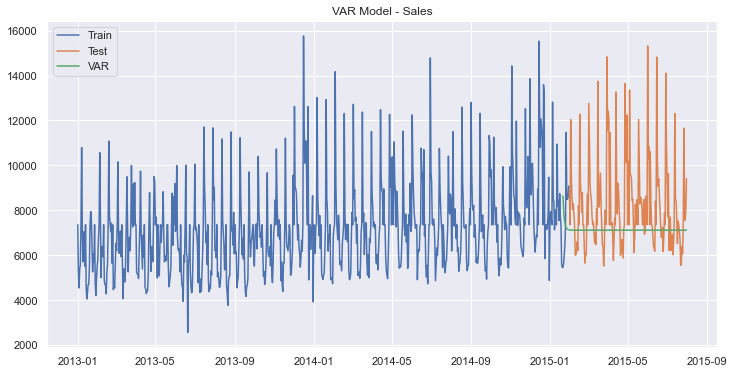

In [175]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [176]:
train_len = 750
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [177]:
train1.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,29,2,7364.775353,653.700899,0,0,a,1,0,8.904464,8.870950,7122.046976,6.482650
2013-01-02,29,3,5269.000000,550.000000,1,0,0,1,0,8.569596,8.889512,7255.476338,6.309918
2013-01-03,29,4,4554.000000,456.000000,1,0,0,1,0,8.423761,8.719221,6119.407958,6.122493
2013-01-04,29,5,5411.000000,505.000000,1,0,0,1,0,8.596189,8.616395,5521.447458,6.224558
2013-01-05,29,6,5564.000000,537.000000,1,0,0,0,0,8.624073,8.682076,5896.273056,6.285998


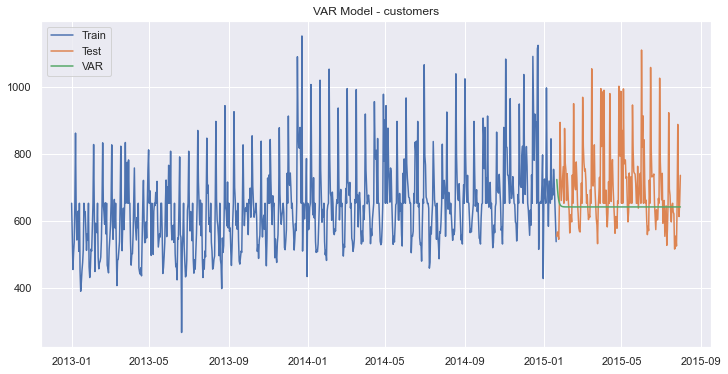

In [178]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

**Model Evalution**


In [179]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test1['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test1['sales']-df_forecast['VAR_forecast_Sales'])/test1['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [180]:
tempResults

,Method,RMSE,MAPE
0,VAR,2299.54,16.51


In [181]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1847.92,11.58
0,VAR,2299.54,16.51


**Johansen-Impulse**

In [182]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [183]:
joh_model1

In [184]:
joh_model1.lr1

array([170.93024957,   1.87906465])

In [185]:
joh_model1.lr2

array([169.05118492,   1.87906465])

In [186]:
new_df[['sales','customers']].shape

(942, 2)

In [187]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [188]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    169.051185  170.930250
1      1.879065    1.879065 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [189]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [190]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

1


**Rank is one**

In [191]:
from statsmodels.tsa.stattools import coint

In [192]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-3.8975102835426023,
 0.009998134852943664,
 array([-3.90811644, -3.3426309 , -3.04896019]))

0.009998134852943664<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**

In [195]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,29,2,7364.775353,653.700899,0,0,1,0,8.904464,8.870950,7122.046976,6.482650,0,1,0,0
2013-01-02,29,3,5269.000000,550.000000,1,0,1,0,8.569596,8.889512,7255.476338,6.309918,1,0,0,0
2013-01-03,29,4,4554.000000,456.000000,1,0,1,0,8.423761,8.719221,6119.407958,6.122493,1,0,0,0
2013-01-04,29,5,5411.000000,505.000000,1,0,1,0,8.596189,8.616395,5521.447458,6.224558,1,0,0,0
2013-01-05,29,6,5564.000000,537.000000,1,0,0,0,8.624073,8.682076,5896.273056,6.285998,1,0,0,0


In [196]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,29,2,7364.775353,653.700899,0,0,1,0,8.904464,8.870950,7122.046976,6.482650,0,1,0,0
2013-01-02,29,3,5269.000000,550.000000,1,0,1,0,8.569596,8.889512,7255.476338,6.309918,1,0,0,0
2013-01-03,29,4,4554.000000,456.000000,1,0,1,0,8.423761,8.719221,6119.407958,6.122493,1,0,0,0
2013-01-04,29,5,5411.000000,505.000000,1,0,1,0,8.596189,8.616395,5521.447458,6.224558,1,0,0,0
2013-01-05,29,6,5564.000000,537.000000,1,0,0,0,8.624073,8.682076,5896.273056,6.285998,1,0,0,0


In [197]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  942
Model:                                VARMAX(1,1)   Log Likelihood                1987.971
Date:                            Sat, 15 Jan 2022   AIC                          -3921.942
Time:                                    17:45:29   BIC                          -3791.046
Sample:                                01-01-2013   HQIC                         -3872.048
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             0.06, 0.01   Jarque-Bera (JB):        240.49, 42.99
Prob(Q):                        0.81, 0.90   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.08, 0.96   Skew:                      0.58, -0.13
Prob(H) (two-sided):

In [198]:
train_len = 750
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [199]:
print(start_index)
print(end_index)

2015-01-21 00:00:00
2015-07-31 00:00:00


In [200]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2015-01-21,29,3,5470.000000,555.000000,1,0,0,0,8.607034,8.707797,6049.899891,6.318968,1,0,0,0
2015-01-22,29,4,5626.000000,568.000000,1,0,0,0,8.635154,8.678721,5876.525924,6.342121,1,0,0,0
2015-01-23,29,5,5997.000000,560.000000,1,0,0,0,8.699015,8.688136,5932.115287,6.327937,1,0,0,0
2015-01-24,29,6,6461.000000,546.000000,1,0,0,0,8.773539,8.742732,6264.988354,6.302619,1,0,0,0
2015-01-25,29,7,7364.775353,653.700899,0,0,0,0,8.904464,8.811557,6711.361584,6.482650,1,0,0,0


In [201]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [202]:
predictions

,sales_log,customers_log
2015-01-21,8.659857,6.328483
2015-01-22,8.659646,6.334951
2015-01-23,8.669776,6.342820
2015-01-24,8.696806,6.347481
2015-01-25,8.891196,6.447788
...,...,...
2015-07-27,8.978664,6.533102
2015-07-28,9.154715,6.651182
2015-07-29,9.036714,6.565770
2015-07-30,8.994661,6.525093


In [203]:
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
2015-01-21,8.659857,6.328483,5766.709302,560.305787
2015-01-22,8.659646,6.334951,5765.492018,563.941577
2015-01-23,8.669776,6.342820,5824.192878,568.396726
2015-01-24,8.696806,6.347481,5983.772326,571.052220
2015-01-25,8.891196,6.447788,7267.705242,631.304128
...,...,...,...,...
2015-07-27,8.978664,6.533102,7932.028147,687.527783
2015-07-28,9.154715,6.651182,9458.933706,773.698442
2015-07-29,9.036714,6.565770,8406.108464,710.358640
2015-07-30,8.994661,6.525093,8059.938381,682.043301


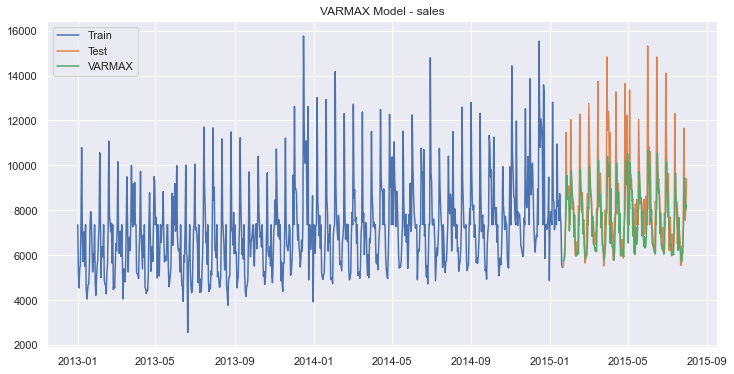

In [204]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

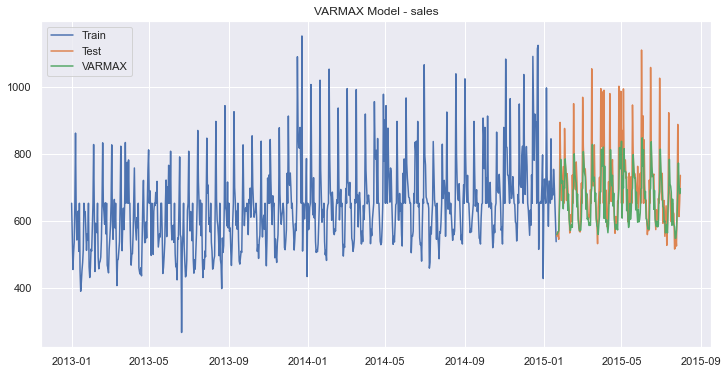

In [205]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

**Model Evalution**

In [206]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [207]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1847.92,11.58
0,VAR,2299.54,16.51
0,VARMAX,1818.60,12.05


**VARMAX is the best model**

-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion


-   The data is stationary
-   Sales and Customers are cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales